In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Sapienza/DL

/content/drive/MyDrive/Sapienza/DL


In [79]:

import pandas as pd
import numpy as np
import json
import itertools
import gensim
import pickle

path="SEMEVAL-2021-task6-corpus/data/"

with open('training_task1_labels.pkl', 'rb') as handle:
    train_labs = pickle.load(handle)

with open('original_training_task1_features.pkl', 'rb') as handle:
    train_feats = pickle.load(handle)

with open('training_task1_all_labels.pkl', 'rb') as handle:
    all_labels = pickle.load(handle)

with open('dev_task1_labels.pkl', 'rb') as handle:
    dev_labs = pickle.load(handle)

with open('original_dev_task1_features.pkl', 'rb') as handle:
    dev_feats = pickle.load(handle)

with open('test_task1_labels.pkl', 'rb') as handle:
    test_labs = pickle.load(handle)

with open('original_test_task1_features.pkl', 'rb') as handle:
    test_feats = pickle.load(handle)


In [80]:
all_labels=np.array(all_labels)
len(all_labels)

23

In [87]:
string_labs=[]

for val in train_labs:
  itemindex = np.where(val==1)[0]
  string_labs.append(all_labels[itemindex].tolist())
string_labs[:3]

[['Black-and-white Fallacy/Dictatorship'],
 [''],
 ['Smears', 'Name calling/Labeling', 'Slogans', 'Loaded Language']]

In [88]:
df={}
df['Text']=train_feats
df['Tags']=string_labs
df=pd.DataFrame(df)
df.head()

,Text,Tags
0,THERE ARE ONLY TWO GENDERS FEMALE MALE,[Black-and-white Fallacy/Dictatorship]
1,This is not an accident!,[]
2,SO BERNIE BROS HAVENT COMMITTED VIOLENCE EH? P...,"[Smears, Name calling/Labeling, Slogans, Loade..."
3,PATHETIC The Cowardly Asshole Weak Failure!!! ...,"[Causal Oversimplification, Smears, Name calli..."
4,WHO TRUMP REPRESENTS WHO DEMOCRATS REPRESENT,[]


In [86]:
val_labs=[]

for val in dev_labs:
  itemindex = np.where(val==1)[0]
  val_labs.append(all_labels[itemindex].tolist())
val_labs[:3]

[[''], ['Name calling/Labeling', 'Loaded Language'], ['']]

In [90]:
df1={}
df1['Text']=dev_feats
df1['Tags']=val_labs
df1=pd.DataFrame(df1)
df1.head()

,Text,Tags
0,"*President* Biden? Please, no.",[]
1,JOE VERSUS THE VOLCANIC KREMLIN DON WILL YOU ...,"[Name calling/Labeling, Loaded Language]"
2,ANTI-VAXXERS BE LIKE... HANG ON A SEC - JUST ...,[]
3,VIRUS BINGO FREE 32 SPACE,[]
4,Never thought ld die fighting IRRESPONSIBLY RU...,"[Name calling/Labeling, Exaggeration/Minimisat..."


In [91]:
df_questions=df

In [111]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_questions.Tags)
labels = multilabel_binarizer.classes_

maxlen = 50
max_words = 3000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df_questions.Text)

def get_features(text_series):
    """
    transforms text data to feature_vectors that can be used in the ml model.
    tokenizer must be available.
    """
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)


def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))

In [112]:
from sklearn.model_selection import train_test_split

x = get_features(df_questions.Text)
y = multilabel_binarizer.transform(df_questions.Tags)
print(x.shape)

x_train=x
y_train=y

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=9000)

(688, 50)


In [113]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   73,
         17,   63,  156,  784,  536, 1294], dtype=int32)

In [114]:
from sklearn.model_selection import train_test_split

x1 = get_features(df1.Text)
y1 = multilabel_binarizer.transform(df1.Tags)
print(x1.shape)


x_test=x1
y_test=y1

(63, 50)


In [78]:
#output dim for embeddings: 60 - 670% acc, 97% val acc
#output dim for embeddings: 40 - 70% acc, 92% val acc

[]

In [107]:
y_test.shape

(63, 23)

In [122]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced',y=y_ints,classes=np.unique(y_ints))
print("cw: ", class_weights)
cw={}
cw[0]=class_weights[0]
cw[1]=class_weights[1]

cw:  [ 0.22910423  8.19047619  2.52014652  0.78004535 16.38095238  2.73015873
  1.5600907   0.76190476  0.86215539  1.72431078  2.18412698  0.13372206
 16.38095238  0.99278499 32.76190476 32.76190476  8.19047619  4.0952381
  0.91005291 16.38095238  8.19047619]


In [126]:
count_label = np.array(tf.reduce_sum(train_labs, axis=0))
print(count_label)

[143.   4.  43.   9.   2.  27.  27. 200.  32.   8.   4. 218.  52.  48.
  18.  20.  44.   1.  40.   4.  20. 358.  13.]


In [127]:
sum(count_label)

1335.0

array([ 0.20918212,  7.47826087,  0.69565217,  3.3236715 , 14.95652174,
        1.1078905 ,  1.1078905 ,  0.14956522,  0.93478261,  3.73913043,
        7.47826087,  0.1372158 ,  0.57525084,  0.62318841,  1.66183575,
        1.49565217,  0.6798419 , 29.91304348,  0.74782609,  7.47826087,
        1.49565217,  0.08355599,  2.30100334])

In [129]:
count_label/max(count_label)

array([0.39944134, 0.01117318, 0.12011173, 0.02513966, 0.00558659,
       0.07541899, 0.07541899, 0.55865922, 0.08938547, 0.02234637,
       0.01117318, 0.60893855, 0.1452514 , 0.13407821, 0.05027933,
       0.05586592, 0.12290503, 0.0027933 , 0.11173184, 0.01117318,
       0.05586592, 1.        , 0.03631285])

In [134]:
counts=x_train.shape[0]/(23*count_label)
cw={}
for i,con in enumerate(counts):
  cw[i]=con

cw

{0: 0.20918212222560048,
 1: 7.478260869565218,
 2: 0.6956521739130435,
 3: 3.323671497584541,
 4: 14.956521739130435,
 5: 1.107890499194847,
 6: 1.107890499194847,
 7: 0.14956521739130435,
 8: 0.9347826086956522,
 9: 3.739130434782609,
 10: 7.478260869565218,
 11: 0.13721579577183884,
 12: 0.5752508361204013,
 13: 0.6231884057971014,
 14: 1.6618357487922706,
 15: 1.4956521739130435,
 16: 0.6798418972332015,
 17: 29.91304347826087,
 18: 0.7478260869565218,
 19: 7.478260869565218,
 20: 1.4956521739130435,
 21: 0.08355598736944377,
 22: 2.301003344481605}

In [135]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(max_words, 80, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(100, 3, padding='valid', activation='relu', strides=1))
#model.add(LSTM(16, return_sequences=True))
model.add(GlobalMaxPool1D())
#model.add(Dropout(0.2))
model.add(Dense(23))
model.add(Activation('sigmoid'))


model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 50, 80)            240000    
                                                                 
 dropout_29 (Dropout)        (None, 50, 80)            0         
                                                                 
 conv1d_30 (Conv1D)          (None, 48, 100)           24100     
                                                                 
 global_max_pooling1d_28 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_39 (Dense)            (None, 23)                2323      
                                                                 
 activation_31 (Activation)  (None, 23)                0         
                                                     

In [137]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])

callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=10, monitor='val_categorical_accuracy',mode="max"), 
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_test,y_test),
                    shuffle=True,
                    callbacks=callbacks,
                    class_weight=cw)

Epoch 1/100
11/11 [==============================] - 2s 74ms/step - loss: 1.3881 - categorical_accuracy: 0.0610 - val_loss: 0.6444 - val_categorical_accuracy: 0.0794 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 1.2385 - categorical_accuracy: 0.1555 - val_loss: 0.5598 - val_categorical_accuracy: 0.2698 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 28ms/step - loss: 1.0166 - categorical_accuracy: 0.3517 - val_loss: 0.4249 - val_categorical_accuracy: 0.2381 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 28ms/step - loss: 0.7458 - categorical_accuracy: 0.3517 - val_loss: 0.3121 - val_categorical_accuracy: 0.2381 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 27ms/step - loss: 0.6158 - categorical_accuracy: 0.3532 - val_loss: 0.2782 - val_categorical_accuracy: 0.2381 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 23ms/step - loss: 0.5799 - categorical_accuracy: 

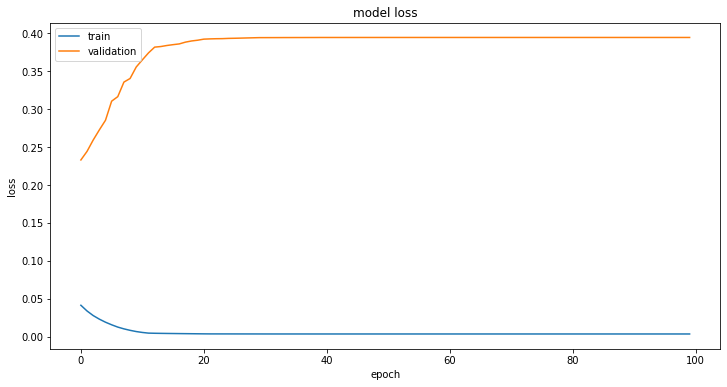

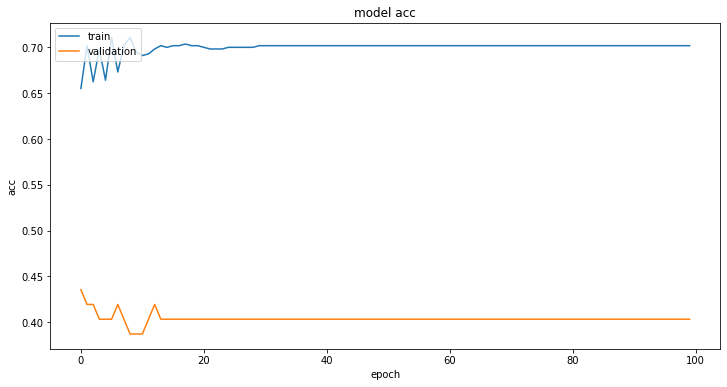

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline


# plotting the validation and training loss i.e. "mean absolute error"
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.close()




plt.figure(figsize=(12,6))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.close()
